# Data Exploration Notebook
This notebook outlines the way we isolated and divided a slice of 'Buzzard' data into training and test datasets for the $p(z,\alpha)$ hack.

In [10]:
import numpy as np
import scipy as sp
from scipy import interpolate

import pyfits
import csv

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as skl
import sklearn.neighbors.kde as kde

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM

import util
import data
import preprocessing

datadir = util.dat_dir()

The true data has many relevant columns, but we will focus on the redshift and 'kcorrect' template coefficients that can be used to derive several otherwise unobservable parameters such as $M_{*}$ and SFH.

In [11]:
tru_hdulist = pyfits.open(datadir+'Buzzard_v1.1_truth.147.fit')
print(tru_hdulist.info())

Filename: /Users/aimalz/Documents/pretzal/dat/Buzzard_v1.1_truth.147.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                BinTableHDU    113   5022692R x 48C   [K, J, J, 5E, 5E, 5E, 5E, 5E, 5E, 5E, E, E, E, J, E, E, J, E, I, E, E, 2E, E, E, E, E, 5E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 2E, E, E]   
None


In [12]:
tru_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  330 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   48 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [13]:
tru_data_all = tru_hdulist[1].data

Because the data is by default sorted by redshift, we take a random sample to work with for speed.  Warning: this step is slow!

In [14]:
n_all = len(tru_data_all)
n_tru = 10000
nredshifts = n_tru
tru_ind = np.random.choice(range(n_all),n_tru)
tru_data = tru_data_all[tru_ind]

The 'kcorrect' templates are only good for $0<z<2$, so we reject the catalog entries outside this range.  Below is plotted the true redshift distribution.

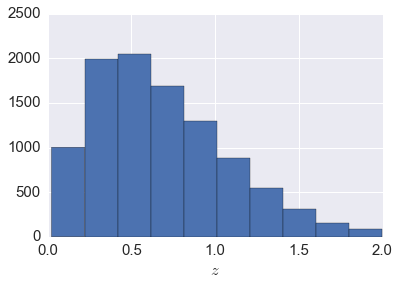

In [15]:
lo_z_ind = np.where(tru_data['Z']<2.)
hi_z_ind = np.where(tru_data['Z']>2.)

# introduced this for testing
# mid_z_ind_lo = np.where(tru_data['Z']<1.05)
# mid_z_ind_hi = np.where(tru_data['Z']>0.95)
# mid_z_ind = np.intersect1d(mid_z_ind_lo,mid_z_ind_hi)

cut_ind = lo_z_ind#np.random.choice(mid_z_ind[0],n_tru)#choose lo, hi (crazy), or mid (for testing)
n_cut = len(cut_ind[0])
cut_data = tru_data[cut_ind]

tru_zs = cut_data['Z']#[tru_ind]
redshift = tru_zs

# warning, KDE is slow!
# X = np.random.choice(tru_data['Z'],10000)
# kde_test = kde.KernelDensity(kernel='gaussian', bandwidth=1.).fit(X.reshape(-1,1))
# X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
# res = kde_test.score_samples(X_plot)
# plt.plot(X_plot[:, 0], res)

plt.hist(tru_zs)
plt.xlabel(r'$z$')

At this point we discovered an issue wherein the absolute magnitudes in the catalog don't agree with those corresponding to the 'kcorrect' template coefficients because they were derived separately from an HOD prescription.  To fix the mismatch between the magnitudes, we applied the following procedure.

1. Create an SED using the 'kcorrect' templates and catalog coefficients.
2. Integrate the SED over the SDSS R band to get the absolute magnitude corresponding to the SED.
3. Calculate the distance modulus from the cosmology used in the simulation and the catalog redshift.
4. Transform the catalog R band apparent magnitude into an absolute magnitude, corresponding to the HOD prescription.
5. Add a constant offset to the SED coefficients such that the two absolute magnitudes match.

Here we plot the SDSS R band filter curve.

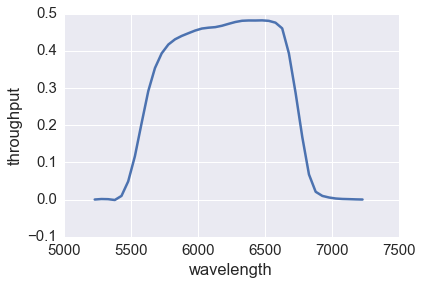

In [16]:
with open(datadir+'sdss_r0.par','rb') as csvfile:
    tuples = (line.split(None) for line in csvfile)
    rfilter = [[pair[k] for k in range(1,len(pair))] for pair in tuples]
    rfilter = np.array([[np.float(r) for r in line] for line in rfilter[74:]])
r_lambda = rfilter.T[0].T
r_filter = rfilter.T[3].T

plt.plot(r_lambda,r_filter)
plt.xlabel('wavelength')
plt.ylabel('throughput')

We plot the 'kcorrect' templates, though something may be wrong here.

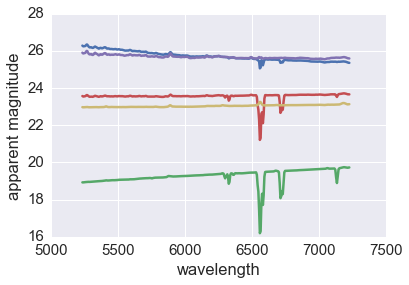

In [17]:
with open(datadir+'lambda.default.dat','rb') as csvfile:
    tuples = (line.split(None) for line in csvfile)
    t_lambda = [np.float(pair[0]) for pair in tuples]
    t_lambda = np.array(t_lambda[1:])
    lambda_difs = t_lambda[1:]-t_lambda[:-1]
    
    t_lambda_r_ind_lo = np.where(t_lambda<max(r_lambda))
    t_lambda_r_ind_hi = np.where(t_lambda>min(r_lambda))
    t_lambda_r_ind = np.intersect1d(t_lambda_r_ind_lo,t_lambda_r_ind_hi)

with open(datadir+'vmatrix.default.dat','rb') as csvfile:
    tuples = (line.split(None) for line in csvfile)

    templates = [np.float(pair[0]) for pair in tuples]
    templates = np.array(templates[1:])
    templates = np.array(np.split(templates, 5))

for t in range(len(templates)):
    plt.plot(t_lambda[t_lambda_r_ind],-2.5*np.log10(lambda_difs[t_lambda_r_ind]*templates[t][t_lambda_r_ind]))
plt.xlabel('wavelength')
plt.ylabel('apparent magnitude')

We interpolate the filter curve to match the template wavelength sampling and plot again to check that it makes sense.

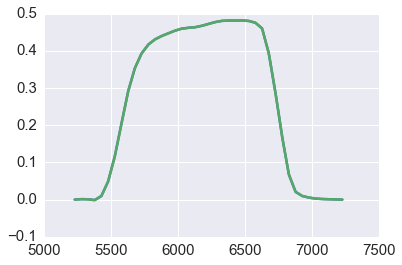

In [18]:
interpolator = sp.interpolate.interp1d(r_lambda,r_filter)
r_filter_matched = interpolator(t_lambda[t_lambda_r_ind])
plt.plot(r_lambda,r_filter)
plt.plot(t_lambda[t_lambda_r_ind],r_filter_matched)

We calculate the R band fluxes for the templates and convert them to apparent magnitudes.  Then we plot the distributions of the template coefficients.

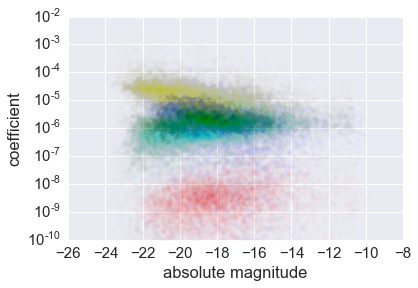

In [20]:
template_r_fluxes = np.array([np.dot(r_filter_matched*templates[t][t_lambda_r_ind],lambda_difs[t_lambda_r_ind]) for t in range(5)])

tru_coeffs = cut_data['COEFFS']
coeffs = tru_coeffs.T

r_fluxes = np.array([np.dot(tru_coeffs[i],template_r_fluxes) for i in range(n_cut)])
r_mags = -2.5*np.log10(r_fluxes)

colors = 'brgycm'
for b in xrange(5):
    #plt.scatter(r_mags,tru_coeffs.T[b][cut_ind],color=colors[b],alpha=0.01)
    plt.scatter(cut_data['AMAG'].T[b],tru_coeffs.T[b],color=colors[b],alpha=0.01)
plt.semilogy()
plt.ylim(1e-10,1e-2)
plt.xlabel('absolute magnitude')
plt.ylabel('coefficient')
#print(np.shape(tru_data['COEFFS'][indices][:,0]),np.shape(tru_data['AMAG'][indices][:,0]))

Here's the identification of the problem with the magnitudes, that the HOD-based ones do not correlate with those derived from the SEDs.

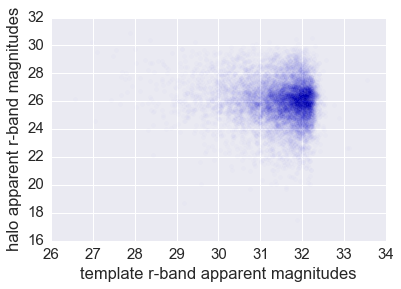

In [21]:
r_fluxes = np.array([np.dot(tru_coeffs[i],template_r_fluxes) for i in range(n_cut)])
r_mags = -2.5*np.log10(r_fluxes)

plt.scatter(r_mags,cut_data['MAG_U'],alpha=0.01)
plt.xlabel('template r-band apparent magnitudes')
plt.ylabel('halo apparent r-band magnitudes')

Here we correct for the mismatch by solving for offsets $x$ in $MAG_{U} = -2.5log_{10}[(COEFF+x)\cdot FLUX_{R,TEMPLATES}]$, yielding $x=\frac{10^{-MAG_{U}/2.5}-\sum_{templates}COEFFS*FLUX_{R,TEMPLATE}}{\sum_{templates}FLUX_{R,TEMPLATE}}$.  This process is slow!  Then we check that it worked

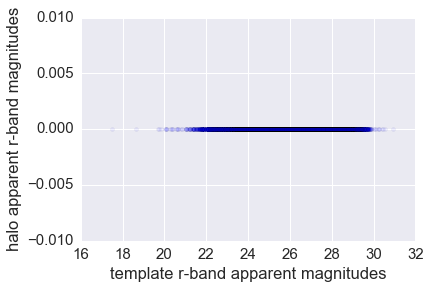

In [22]:
factors = np.zeros(n_cut)
factors = np.sum(coeffs.T*template_r_fluxes,axis=1)
factors = 10**(-1.*cut_data['MAG_U']/2.5)-factors
# for i in range(n_cut):
#     factors[i] = 10.**(-1.*cut_data['MAG_U'][i]/2.5)-np.sum(coeffs.T[i]*template_r_fluxes)
factors = factors/np.sum(template_r_fluxes)
coeffs = coeffs+factors

r_fluxes = np.sum(coeffs.T*template_r_fluxes,axis=1)
r_mags = -2.5*np.log10(r_fluxes)

for b in xrange(5):
   plt.scatter(r_mags,cut_data['MAG_U']-r_mags,alpha=0.01)
plt.xlabel('template r-band apparent magnitudes')
plt.ylabel('halo apparent r-band magnitudes')

Next we turn the absolute magnitudes into galaxy properties that cannot be directly observed using 'kcorrect' relationships.

In [23]:
#info from the kcorrect.pro documentation:

#Outputs:

#   mass          - [ngals] model mass derived from the coeffs (current
#                   surviving stellar mass)
#   intsfh        - [ngals] total integrated star-formation history (number of
#                   stars formed total)
#   mets          - [ngals] average metallicity of currently surviving stars
#   mtol          - [nk, ngals] model mass-to-light in each *final*
#                   bandpass (the bandpass you are kcorrecting *to*)
#                   in SOLAR UNITS!
#   b300          - star-formation within last 300Myrs relative to
#                   average star-formation rate
#   b1000         - star-formation within last 1Gyrs relative to
#                   average star-formation rate




#   For v4_0b templates and later, coefficients are in units of: 
# 
#     1 solar mass / (D/10pc)^2 
#
#   That is, sum the coefficients and multiply by (D/10pc)^2 to get
#   TOTAL INTEGRATED STAR FORMATION. (In fact, for Omega0=0.3 and
#   OmegaL0=0.7, this is what the "mass" keyword returns). Note that
#   the total integrated star formation DIFFERS from the current
#   stellar mass --- which is returned in the mass and mtol variables.

directory=datadir
tspecfile=directory+'k_nmf_derived.default.fits'
t=fits.open(tspecfile)

#read in coefficients for each template
tbdata=t[18].data
tmass=t[16].data
tmremain=t[17].data
tmetallicity=t[18].data
tmass300=t[19].data
tmass1000=t[20].data

cosmology=FlatLambdaCDM(H0=70, Om0=0.286)

#initialize arrays
nredshifts = n_cut

b300=np.zeros(nredshifts)
b1000=np.zeros(nredshifts)
tmp_mass=np.zeros(nredshifts)
mets=np.zeros(nredshifts)
mass=np.zeros(nredshifts)
intsfh=np.zeros(nredshifts)

dmod=cosmology.distmod(redshift)
# do all the calculations, looping over objects
for i in np.arange(n_cut):#nredshifts):
    b300[i]=np.sum(tmass300*coeffs[:,i])/np.sum(tmass*coeffs[:,i])
    b1000[i]=np.sum(tmass1000*coeffs[:,i])/np.sum(tmass*coeffs[:,i])
    tmp_mass[i]=np.sum(tmremain*coeffs[:,i])
    mets[i]=np.sum(tmremain*tmetallicity*coeffs[:,i])/tmp_mass[i]
    mass[i]=tmp_mass[i]*10.**(0.4*dmod.value[i])
    intsfh[i]=np.sum(coeffs[:,i])*10.**(0.4*dmod.value[i])

Now comes the data exploration!  We plot the absolute magnitude distributions, color distributions, and stellar mass function as well as stellar mass vs. color, color vs. magnitude, mass-to-light-ratio vs. color, and stellar mass vs. absolute magnitude.  We expect to observe Schechter functions for some of these distributions.

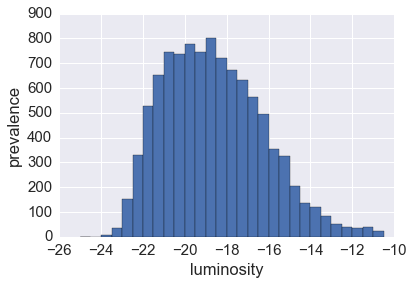

In [24]:
bins = np.arange(-25,-10,0.5)
plt.hist(tru_data['AMAG'][:,2],bins=bins)
plt.xlabel('luminosity')
plt.ylabel('prevalence')

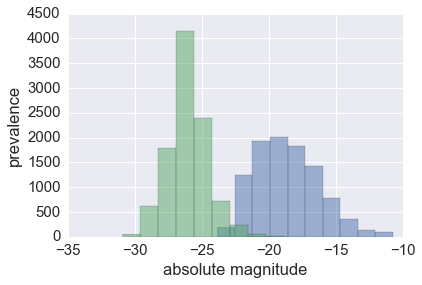

In [25]:
# seek Schechter function
# bins = np.arange(8,14,0.1)
plt.hist(tru_data['AMAG'][cut_ind][:,2],alpha=0.5)#,bins=bins)
plt.hist(-1.*tru_data['MAG_U'][cut_ind],alpha=0.5)
plt.xlabel('absolute magnitude')
plt.ylabel('prevalence')

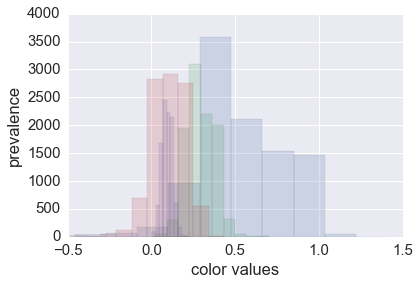

In [26]:
colors = tru_data['AMAG'][cut_ind][:,:-1]-tru_data['AMAG'][cut_ind][:,1:]

for i in range(4):
    plt.hist(colors.T[i],alpha=0.2)
plt.xlabel('color values')
plt.ylabel('prevalence')

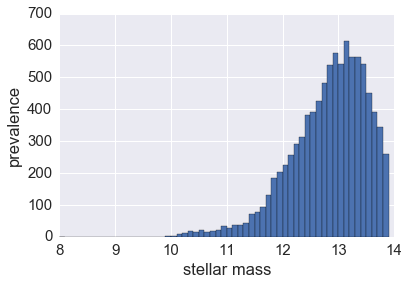

In [27]:
# seek Schechter function
bins = np.arange(8,14,0.1)
plt.hist(np.log10(mass),bins=bins)
plt.xlabel('stellar mass')
plt.ylabel('prevalence')

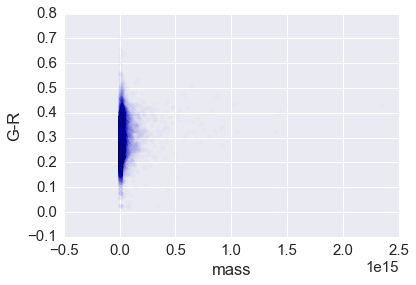

In [29]:
# mass to color distribution
# The colors and masses are not correlated due to the error in the forward model of the data.
plt.scatter(mass,colors.T[1],alpha=0.01)
plt.xlabel('mass')
plt.ylabel('G-R')

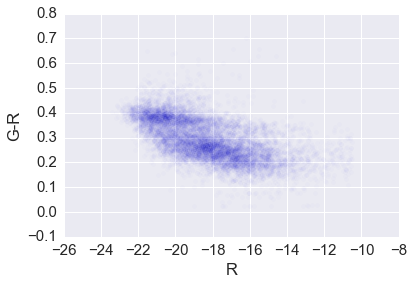

In [30]:
# magnitude to color distribution
plt.scatter(tru_data['AMAG'][cut_ind][:,1],colors.T[1],alpha=0.01)
plt.xlabel('R')
plt.ylabel('G-R')

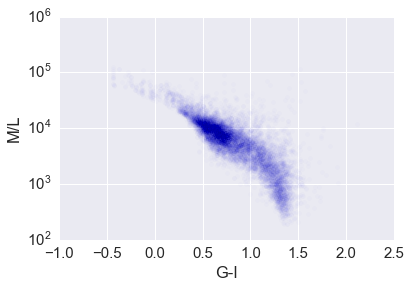

In [31]:
# mass to light distribution
# We use the Bruzual and Charlot constants to transform the absolute magnitudes into mass-to-light ratios.
mtol_est = 10**(-0.68+0.7*(tru_data['AMAG'][cut_ind][:,0]-tru_data['AMAG'][cut_ind][:,2]))
mtol = mass/10**(0.4*(4.7-tru_data['AMAG'][cut_ind][:,1]))
plt.scatter(tru_data['AMAG'][cut_ind][:,0]-tru_data['AMAG'][cut_ind][:,2],mtol,alpha=0.01)
plt.scatter(tru_data['AMAG'][cut_ind][:,0]-tru_data['AMAG'][cut_ind][:,2],mtol_est,color='r')
plt.semilogy()
plt.xlabel('G-I')
plt.ylabel('M/L')

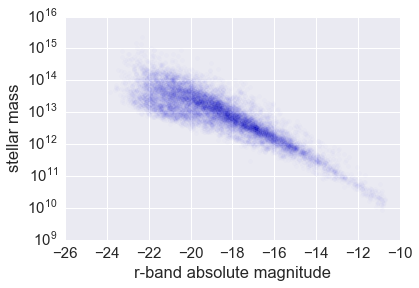

In [32]:
# stellar mass vs. absolute mag, seek Schechter function
plt.scatter(tru_data['AMAG'][cut_ind][:,2],mass,alpha=0.01)
plt.semilogy()
plt.ylabel('stellar mass')
plt.xlabel('r-band absolute magnitude')

Now we explore the "observed" data.

In [33]:
obs_hdulist = pyfits.open(datadir+'Buzzard_v1.1.147.fit')
print(obs_hdulist.info())

Filename: /Users/aimalz/Documents/pretzal/dat/Buzzard_v1.1.147.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                BinTableHDU     87   5022692R x 35C   [K, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
None


In [34]:
obs_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  144 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   35 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [35]:
obs_data_all = obs_hdulist[1].data

We plot the redshift distribution of the observed data using the photo-$z$s and note it differs from the true redshift distribution.

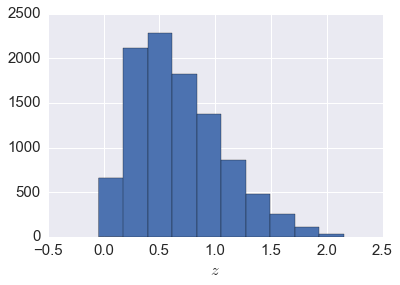

In [36]:
# warning, KDE is slow!
# X = np.random.choice(obs_data['PHOTOZ_GAUSSIAN'],10000)
# kde_test = kde.KernelDensity(kernel='gaussian', bandwidth=1.).fit(X.reshape(-1,1))
# X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
# res = kde_test.score_samples(X_plot)
# indices = np.random.choice(range(0,len(obs_data)),10000)
indices = tru_ind
obs_data = obs_data_all[tru_ind]
obs_data = obs_data[cut_ind]

plt.hist(obs_data['PHOTOZ_GAUSSIAN'])
plt.xlabel(r'$z$')

However, there is in geeral low scatter and no special outlier populations in the relationship between true redshifts and photo-$z$s.

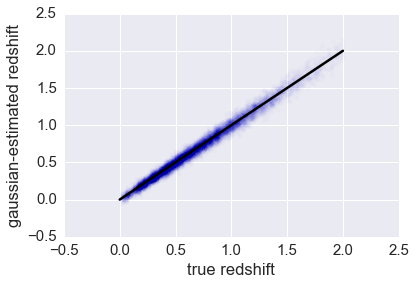

In [37]:
plt.scatter(tru_zs,obs_data['PHOTOZ_GAUSSIAN'],alpha=0.01)
plt.plot([0.,2.],[0.,2.],color='k')
plt.xlabel('true redshift')
plt.ylabel('gaussian-estimated redshift')